# CNN Interpretation with CAM 
Visualising class activation maps with `fastai`
* Grad-CAM creates a coarse heat-map corresponding with CNN activations
* This heatmap can be superimposed over the input image to reveal areas of significance

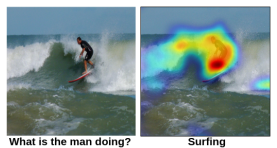

### 1. Dependencies
Instructions for linux, or install with conda for windows https://pytorch.org/get-started/locally/  
`> conda install cuda -c nvidia`  
`> conda search -f cuda`  
`> conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch`  
`> nvcc --version`

In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


Bad key text.latex.preview in file D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
# check for latest release https://pypi.org/project/timm/0.6.2.dev0/#history
!pip install -Uqq timm==0.6.2.dev0

In [3]:
import torch
import fastai
from fastbook import *
import timm
print(f' Fastai {fastai.__version__}\nPytorch {torch.__version__}\n   Timm {timm.__version__}')
try:
    free, total = torch.cuda.mem_get_info()
    print(f'    GPU {torch.cuda.get_device_name(0)} ({total//1024**2} MB)')
except: print("No GPU detected")

 Fastai 2.7.6
Pytorch 1.12.0
   Timm 0.6.2.dev0
    GPU NVIDIA GeForce RTX 2070 (8191 MB)


### 2. FastAI Pets Dataset

In [4]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): 
    return x[0].isupper()

# data loader
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224), bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [5]:
# resnet learner
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

D:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
D:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.139323,0.043857,0.012179,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.081753,0.020771,0.008796,01:13
1,0.036914,0.008384,0.001353,01:13


Alternative (more performant) models from [timm](https://github.com/rwightman/pytorch-image-models)
```
# convnext learner
learn = vision_learner(dls, arch="convnext_small_in22k", metrics=error_rate).to_fp16()
learn.fine_tune(1)
```
```
# vit learner
learn = vision_learner(dls, arch="vit_tiny_patch16_224", metrics=error_rate).to_fp16()
learn.fine_tune(1)
```

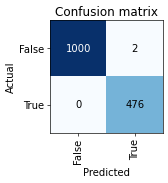

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

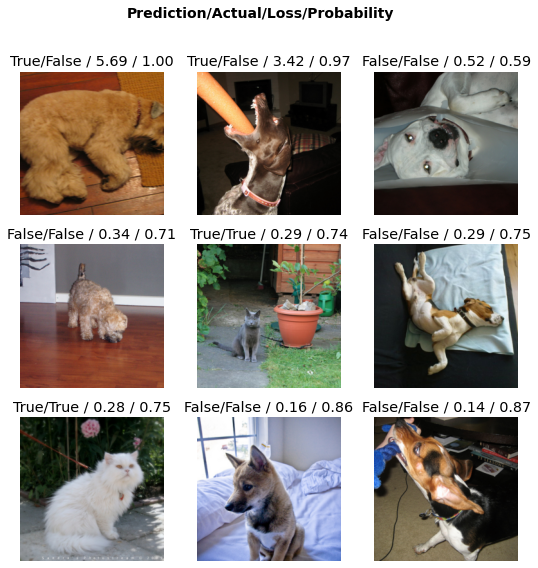

In [37]:
interp.plot_top_losses(9, nrows=3)

### 3. Get example image

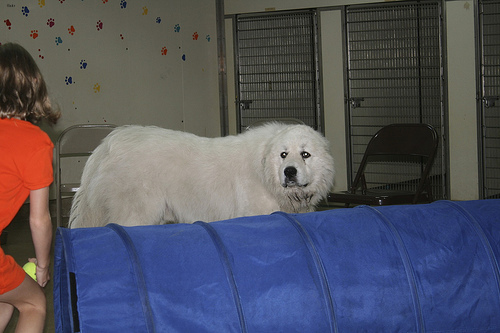

In [6]:
def get_sample(n=0):
    """Get image from dataset and pass through pre-processing"""
    img = PILImage.create((path).ls()[n])
    x, = first(dls.test_dl([img]))         
    return img, x

img, x = get_sample(n=3156) # (n=4451)
img

> For CAM we want to store the activations of the last convolutional layer. We put our hook function in a class so it has a state that we can access later, and just store a copy of the output:

In [7]:
# add hook to final activation layer
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [8]:
with torch.no_grad(): output = learn.model.eval()(x)

act = hook_output.stored[0]

In [9]:
# double check prediction (dog)
F.softmax(output, dim=-1)

TensorBase([[9.9991e-01, 9.4807e-05]], device='cuda:0')

In [10]:
# we know 0 (for False) is "dog" aka not-cat
dls.vocab

[False, True]

With a high degree of `False`, our model is confident it is not a cat.
> Which pixels have the highest influence over this prediction?

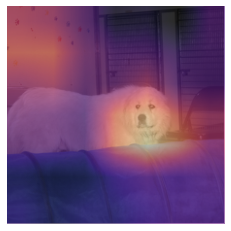

In [11]:
# image activations over the final layer
cam_map= torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)

x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

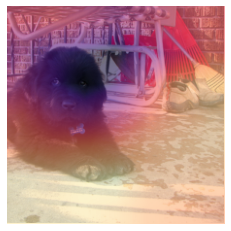

In [40]:
def plot_cam_activation(n=1, ret=False):
    """Returns final activation layer representation from a sample image"""
    img, x = get_sample(n=n)  # (n=4451) 140

    with torch.no_grad(): output = learn.model.eval()(x)
    act = hook_output.stored[0]

    cam_map= torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)

    x_dec = TensorImage(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                  interpolation='bilinear', cmap='magma');
    if ret == True: return x_dec

plot_cam_activation(n=4451)

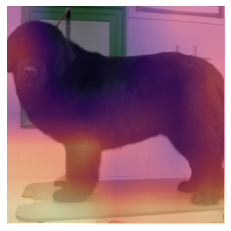

In [41]:
plot_cam_activation(n=4471)

In [12]:
# Once you're done with your hook, you should remove it as otherwise it might leak some memory:
hook.remove()

> That's why it's usually a good idea to have the Hook class be a context manager, registering the hook when you enter it and removing it when you exit.

In [13]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [14]:
# we can safely use it this way:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

> This method is useful, but only works for the last layer. *Gradient CAM* is a variant that addresses this problem.

## Gradient CAM
> The method we just saw only lets us compute a heatmap with the last activations, since once we have our features, we have to multiply them by the last weight matrix. This won't work for inner layers in the network. A variant introduced in the paper ["Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1611.07450) in 2016 uses the gradients of the final activation for the desired class.

In [15]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [16]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [17]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

> The weights for our Grad-CAM are given by the average of our gradients across the feature map. Then it's exactly the same as before:

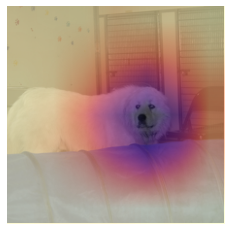

In [18]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

> The novelty with Grad-CAM is that we can use it on any layer. For example, here we use it on the output of the second-to-last ResNet group:

In [19]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [20]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

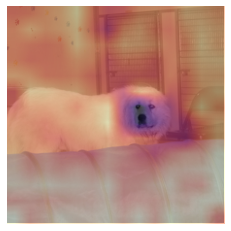

In [21]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');